# Rank Funding Agencies

## Years: 2008-2018

In [53]:
import time
import requests
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from py2neo import Graph, Node, Relationship
import os
import math

min_year = 2008
max_year = 2018
years = '[%d : %d]' % (min_year, max_year)
grants_data_dir = "grants"
pubs_data_dir = "publications"

In [3]:
import requests

#   The credentials to be used
login = {
    'username': 'jww@mit.edu',
    'password': 'e38qDkG$tJ'
}

#   Send credentials to login url to retrieve token. Raise
#   an error, if the return code indicates a problem.
#   Please use the URL of the system you'd like to access the API
#   in the example below.
resp_auth = requests.post('https://app.dimensions.ai/api/auth.json', json=login)
resp_auth.raise_for_status()

#   Create http header using the generated token.
headers = {
    'Authorization': "JWT " + resp_auth.json()['token']
}

In [4]:
# long numbers to human readable string
def human_format(num):
    try:
        num = float('{:.3g}'.format(float(num)))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    except:
        return num

In [5]:
from requests.exceptions import HTTPError
def dimensions_to_df(query):
    try:
        resp = requests.post(
            'https://app.dimensions.ai/api/dsl.json',
            data=query.encode(),
            headers=headers)
        resp.raise_for_status()
    except HTTPError as http_err:
        print('Error while executing query: ', query)
        raise http_err
    ret = resp.json()
    keys = list(ret.keys())
    keys.remove('_stats')
    if len(keys):
        df = pd.DataFrame(ret[keys[0]])
    else:
        df = pd.DataFrame()
    return df, ret['_stats']

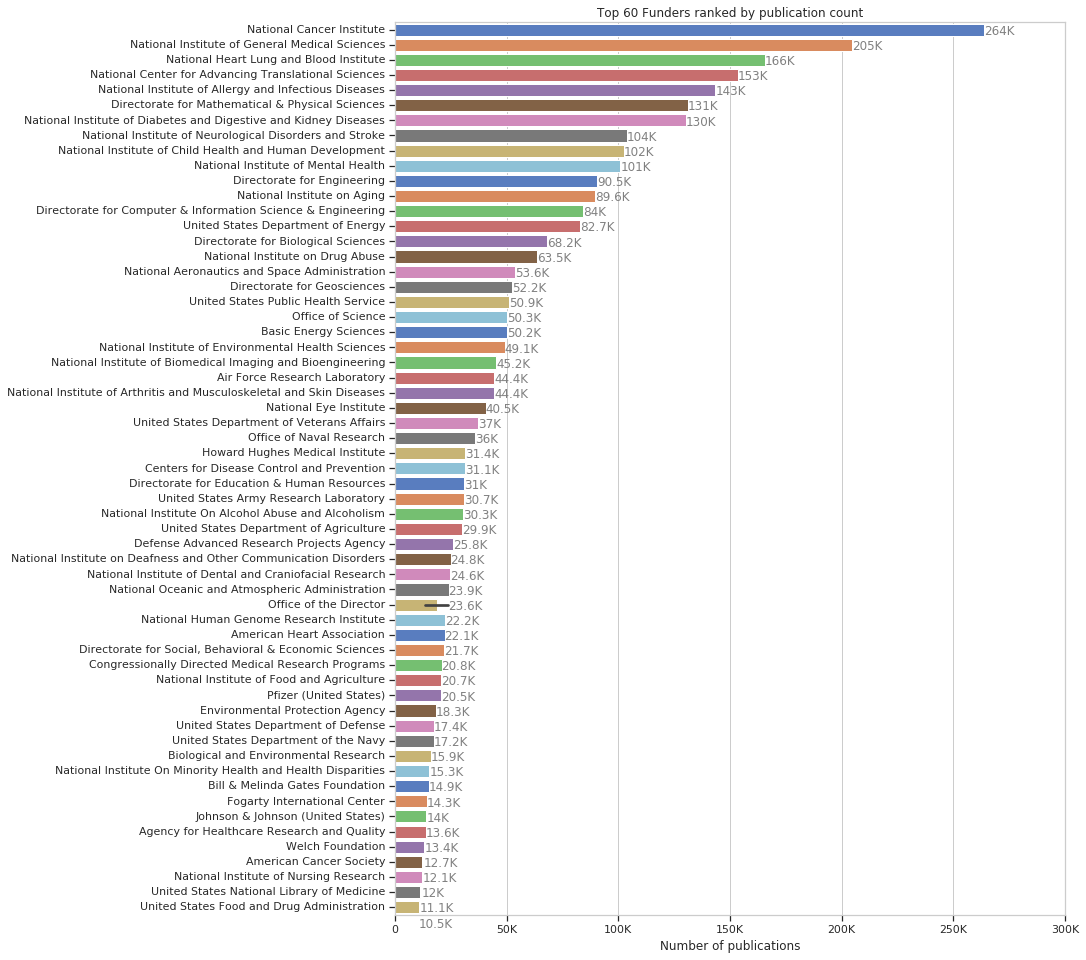

In [90]:
# US Funders ranked by number of publications

query = (
    'search publications ' +
    'where funder_countries = "US" ' +
    'and year in ' + years + 
    ' return funders limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "count", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 Funders ranked by publication count')
ax.set_ylabel('')
ax.set_xlabel('Number of publications')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['count'], index + 0.33, human_format(row['count']), color='gray')
plt.show()

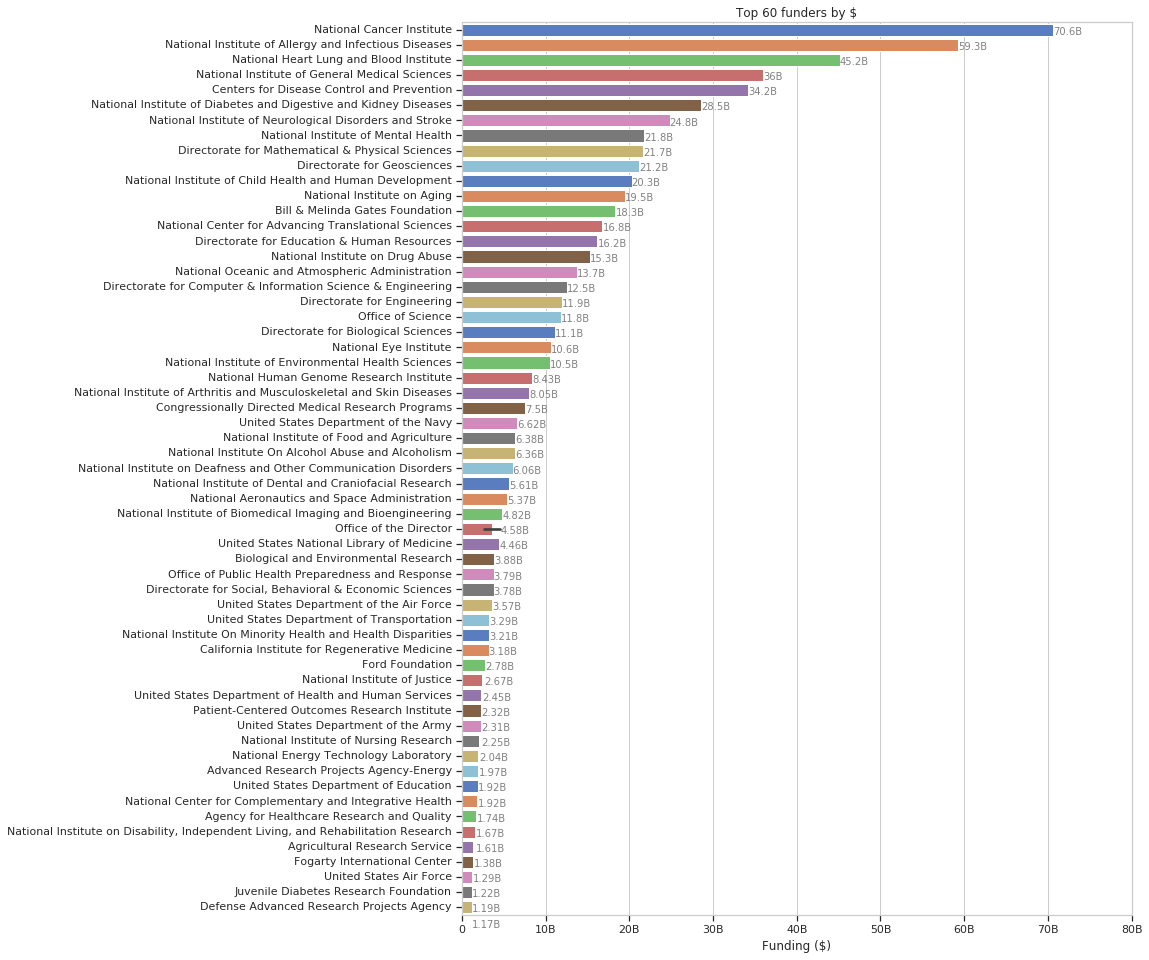

In [9]:
# US funders ranked by funding amount

query = (
    'search grants ' +
    'where funder_countries = "US" ' +
    'and active_year in ' + years + 
    ' return funders ' +
    'aggregate funding ' +
    'sort by funding desc limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()
top100 = df[df['country_name'] == 'United States'].head(100).reset_index()
over100m = df[df['country_name'] == 'United States']
over100m = df[df['funding'] > 1e8]


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "funding", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 funders by $')
ax.set_ylabel('')
ax.set_xlabel('Funding ($)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['funding'], index + 0.33, human_format(row['funding']), color='gray')
plt.show()

In [62]:
# Fetch all grants for all top 100 funders

# NOTICE - run this only if you want the grant data stored locally

for index, row in over100m.iterrows(): 
    if row['name'] == 'Alfred P. Sloan Foundation':
        filename = "%s/%s.csv" % (grants_data_dir, row['name'])
    else:
        filename = "%s/%s.csv" % (grants_data_dir, row['acronym'])
    if os.path.isfile(filename):
        continue
    
    print("Fetching grants for #%d - %s" % (index, row['name']))
    query = (
        'search grants ' +
        'where funders.name = "' + row['name'] + '" ' + 
        'and active_year in ' + years + 
        'return grants [all - abstract - original_title] ' + 
        'sort by id ' +
        'limit 1000 skip '
    )

    big_df, stats = dimensions_to_df(query + "0")
    total = stats['total_count']

    if total > 50000:
        raise Exception("Total number of grants for this funder exceeds the maximum fetch-able amount", total)

    start = 1
    step = 1000
    idx = start
    for i in range(start * step, total, step):
        time.sleep(2)
        print("%.1f%%" % (float(i) * 100 / total))
        df, stats = dimensions_to_df(query + "%d" % i)
        big_df = pd.concat([big_df, df])
        
    big_df.to_csv(filename)
    print("Done. Saved to " + filename)

print("ALL Done.")

MRA
Fetching grants for #100 - Melanoma Research Alliance
Done. Saved to grants/MRA.csv
NSA
Fetching grants for #102 - National Security Agency
Done. Saved to grants/NSA.csv
Beckman
Fetching grants for #103 - Arnold and Mabel Beckman Foundation
Done. Saved to grants/Beckman.csv
ALL Done.


In [10]:
# Aggregate publications

names = ['"%s"' % s for s in over100m['name']]

query = (
    'search publications ' +
    'where funders.name in [' + ','.join(names) + '] ' + 
    'and year in ' + years + 
    ' return funders ' + 
    'aggregate count, citations_total, citations_avg, altmetric_median, rcr_avg, fcr_gavg ' +
    'limit 1000'
)
df, stats = dimensions_to_df(query)
metrics = df[df['name'].isin(over100m['name'])]

In [11]:
new_df = pd.merge(over100m[['name', 'funding', 'count']], metrics, on='name')
new_df.rename(columns={'count_x':'count_grants',
                                'count_y':'count_publications'},inplace=True)
new_df

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg
0,National Cancer Institute,7.063250e+10,33125,NCI,3.000000,38.890631,11008771.0,283070,United States,3.026209,grid.48336.3a,1.874898
1,National Institute of Allergy and Infectious D...,5.927476e+10,28634,NIAID,3.000000,35.538767,5096508.0,143407,United States,2.799259,grid.419681.3,1.808636
2,National Heart Lung and Blood Institute,4.515525e+10,22594,NHLBI,3.000000,35.260045,5838605.0,165587,United States,3.223373,grid.279885.9,1.819178
3,National Institute of General Medical Sciences,3.599162e+10,18946,NIGMS,3.000000,37.237648,7625116.0,204769,United States,2.819553,grid.280785.0,1.768594
4,Centers for Disease Control and Prevention,3.416329e+10,10578,CDC,3.303867,24.150112,753725.0,31210,United States,2.483707,grid.416738.f,1.751464
5,National Institute of Diabetes and Digestive a...,2.853167e+10,16115,NIDDK,3.000000,38.944990,5072507.0,130248,United States,3.286129,grid.419635.c,2.007236
6,National Institute of Neurological Disorders a...,2.479693e+10,16684,NINDS,3.000000,39.252681,4073761.0,103783,United States,3.195006,grid.416870.c,1.980798
7,National Institute of Mental Health,2.175291e+10,13542,NIMH,3.000000,38.517024,3883633.0,100829,United States,3.642476,grid.416868.5,2.091119
8,Directorate for Mathematical & Physical Sciences,2.168878e+10,36979,NSF MPS,2.000000,23.477998,3074256.0,130942,United States,2.651916,grid.457875.c,1.271579
9,Directorate for Geosciences,2.120403e+10,24944,NSF GEO,3.000000,25.028212,1305897.0,52177,United States,2.829530,grid.457836.b,1.230021


In [63]:
# correction for future and past fundings
import math
new_df['funding_correction'] = 0
for index, row in new_df.iterrows(): 
    print("Loading grants for #%d - %s" % (index, row['name']))
    if row['name'] == "Alfred P. Sloan Foundation":
        df = pd.read_csv('%s/Alfred P. Sloan Foundation.csv' % grants_data_dir)
    else:
        df = pd.read_csv('%s/%s.csv' % (grants_data_dir, row['acronym']))
    deduct_funding = 0
    for index2, row2 in df[df['active_year'].str.contains('2019') | df['active_year'].str.contains('2007')].iterrows():
        if not math.isnan(row2['funding_usd']):
            active_years = [int(s.strip()) for s in row2['active_year'][1:-1].split(',')]
            non_relevant_years = [year for year in active_years if year > max_year or year < min_year]
            deduct_funding += float(len(non_relevant_years)) * row2['funding_usd'] / len(active_years)
    new_df.loc[index, 'funding_correction'] = deduct_funding

print("ALL Done.")
new_df["funding_corrected"] = new_df["funding"] - new_df["funding_correction"]

Loading grants for #0 - National Cancer Institute


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading grants for #1 - National Institute of Allergy and Infectious Diseases
Loading grants for #2 - National Heart Lung and Blood Institute
Loading grants for #3 - National Institute of General Medical Sciences
Loading grants for #4 - Centers for Disease Control and Prevention
Loading grants for #5 - National Institute of Diabetes and Digestive and Kidney Diseases
Loading grants for #6 - National Institute of Neurological Disorders and Stroke
Loading grants for #7 - National Institute of Mental Health
Loading grants for #8 - Directorate for Mathematical & Physical Sciences
Loading grants for #9 - Directorate for Geosciences
Loading grants for #10 - National Institute of Child Health and Human Development
Loading grants for #11 - National Institute on Aging
Loading grants for #12 - Bill & Melinda Gates Foundation
Loading grants for #13 - National Center for Advancing Translational Sciences
Loading grants for #14 - Directorate for Education & Human Resources
Loading grants for #15 - Na

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading grants for #32 - National Institute of Biomedical Imaging and Bioengineering
Loading grants for #33 - Office of the Director
Loading grants for #34 - Office of the Director
Loading grants for #35 - Office of the Director
Loading grants for #36 - Office of the Director
Loading grants for #37 - United States National Library of Medicine
Loading grants for #38 - Biological and Environmental Research
Loading grants for #39 - Office of Public Health Preparedness and Response
Loading grants for #40 - Directorate for Social, Behavioral & Economic Sciences
Loading grants for #41 - United States Department of Transportation
Loading grants for #42 - National Institute On Minority Health and Health Disparities
Loading grants for #43 - California Institute for Regenerative Medicine
Loading grants for #44 - National Institute of Justice
Loading grants for #45 - United States Department of Health and Human Services
Loading grants for #46 - Patient-Centered Outcomes Research Institute
Loading

,name,funding,funding_correction
0,National Cancer Institute,7.063250e+10,2.476890e+10
1,National Institute of Allergy and Infectious D...,5.927476e+10,1.765870e+10
2,National Heart Lung and Blood Institute,4.515525e+10,1.571721e+10
3,National Institute of General Medical Sciences,3.599162e+10,1.572018e+10
4,Centers for Disease Control and Prevention,3.416329e+10,4.166974e+09
5,National Institute of Diabetes and Digestive a...,2.853167e+10,1.071943e+10
6,National Institute of Neurological Disorders a...,2.479693e+10,8.896594e+09
7,National Institute of Mental Health,2.175291e+10,7.075433e+09
8,Directorate for Mathematical & Physical Sciences,2.168878e+10,5.808971e+09
9,Directorate for Geosciences,2.120403e+10,6.639243e+09


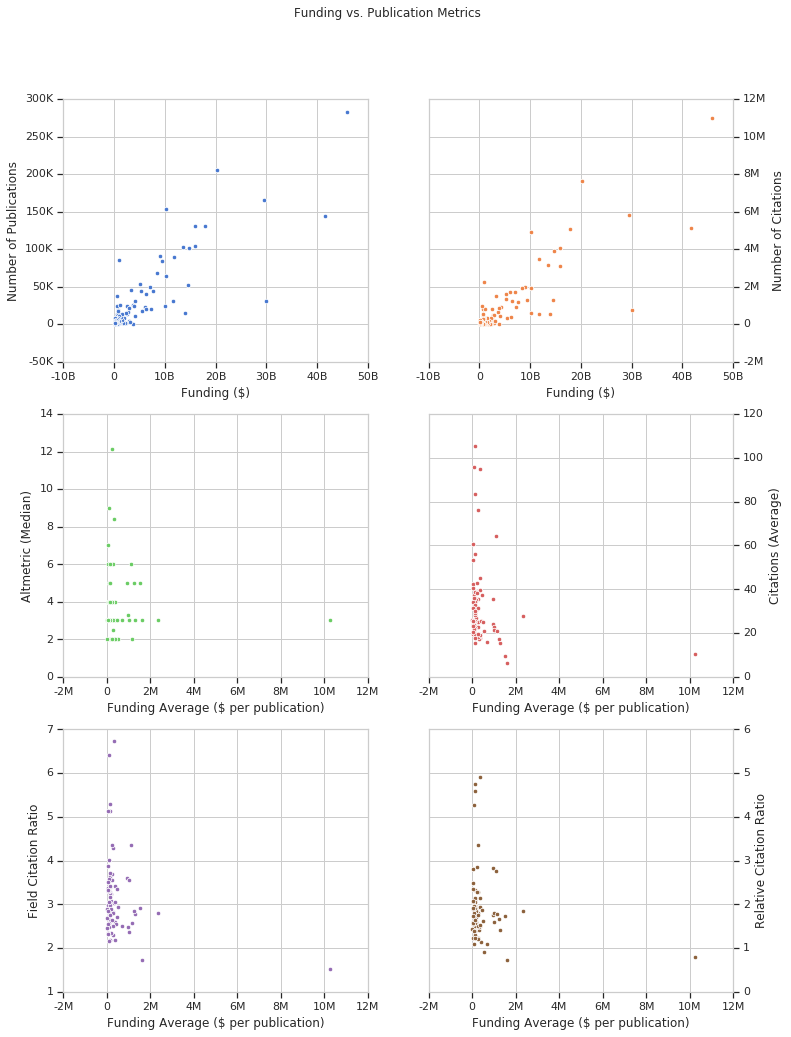

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(12,16))
fig.suptitle('Funding vs. Publication Metrics') 
colors = np.array(sns.color_palette("muted"))

new_df["funding_avg"] = new_df["funding_corrected"] / new_df["count_publications"]

sns.scatterplot(ax = axes[0][0], x="funding_corrected", y="count_publications", data=new_df, color=colors[0])
axes[0][0].set_ylabel('Number of Publications')
axes[0][0].yaxis.tick_left()
axes[0][0].set_yticklabels([human_format(tick) for tick in axes[0][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[0][1], x="funding_corrected", y="citations_total", data=new_df, color=colors[1])
axes[0][1].set_ylabel('Number of Citations')
axes[0][1].yaxis.set_label_position("right")
axes[0][1].yaxis.tick_right()
axes[0][1].set_yticklabels([human_format(tick) for tick in axes[0][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][0], x="funding_avg", y="altmetric_median", data=new_df, color=colors[2])
axes[1][0].set_ylabel('Altmetric (Median)')
axes[1][0].yaxis.tick_left()
axes[1][0].set_yticklabels([human_format(tick) for tick in axes[1][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][1], x="funding_avg", y="citations_avg", data=new_df, color=colors[3])
axes[1][1].set_ylabel('Citations (Average)')
axes[1][1].yaxis.set_label_position("right")
axes[1][1].yaxis.tick_right()
axes[1][1].set_yticklabels([human_format(tick) for tick in axes[1][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][0], x="funding_avg", y="fcr_gavg", data=new_df, color=colors[4])
axes[2][0].set_ylabel('Field Citation Ratio')
axes[2][0].yaxis.tick_left()
axes[2][0].set_yticklabels([human_format(tick) for tick in axes[2][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][1], x="funding_avg", y="rcr_avg", data=new_df, color=colors[5])
axes[2][1].set_ylabel('Relative Citation Ratio')
axes[2][1].yaxis.set_label_position("right")
axes[2][1].yaxis.tick_right()
axes[2][1].set_yticklabels([human_format(tick) for tick in axes[2][1].get_yticks().tolist()])

for i in range(len(axes)):
    for ax in axes[i]:
        ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
        if i == 0:
            ax.set_xlabel('Funding ($)')
        else:
            ax.set_xlabel('Funding Average ($ per publication)')
        ax.xaxis.tick_bottom()

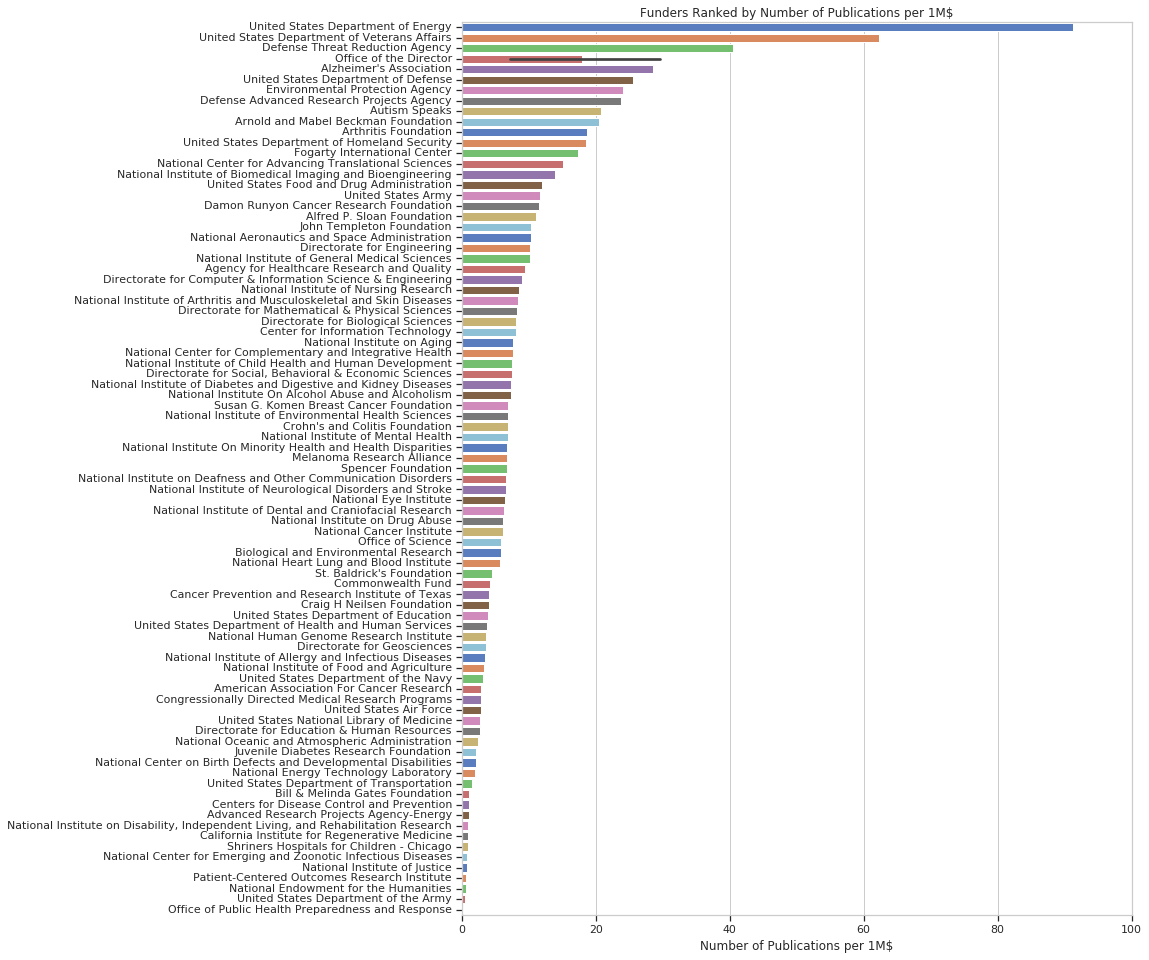

In [66]:
# Rank funders by publications per $
new_df['pub_per_$'] = new_df['count_publications'] * 1000000 / new_df['funding_corrected']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "pub_per_$", data=new_df.sort_values(by=['pub_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Number of Publications per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Number of Publications per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

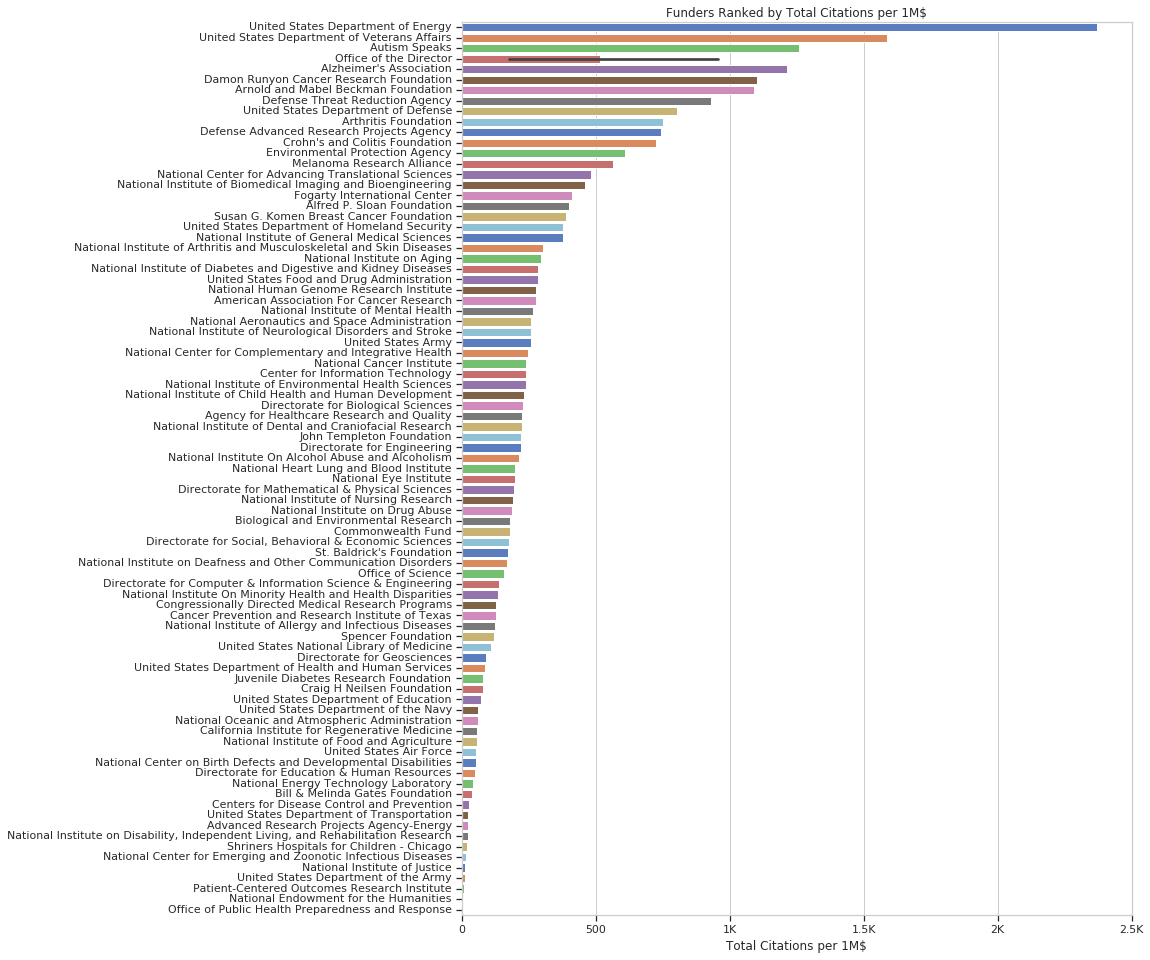

In [67]:
# Rank funders by publications per $
new_df['cite_total_per_$'] = new_df['citations_total'] * 1000000 / new_df['funding_corrected']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "cite_total_per_$", data=new_df.sort_values(by=['cite_total_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Total Citations per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Total Citations per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

In [68]:
funders = [
    'Alfred P. Sloan Foundation',
    'Bill & Melinda Gates Foundation',
    'Defense Advanced Research Projects Agency',
    'United States Department of Defense'
]

new_df[new_df['name'].isin(funders)]

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg,pub_per_$,cite_total_per_$,funding_correction,funding_corrected,funding_avg
12,Bill & Melinda Gates Foundation,1.833299e+10,6425,BMGF,5.0,35.344225,527866.0,14935,United States,3.606891,grid.418309.7,2.825479,1.066287,37.687088,4.326447e+09,1.400655e+10,937833.808796
58,Defense Advanced Research Projects Agency,1.167393e+09,2127,DARPA,3.0,31.269055,807367.0,25820,United States,3.368079,grid.421816.8,1.897636,23.782944,743.670198,8.174105e+07,1.085652e+09,42046.938374
66,United States Department of Defense,7.866445e+08,1500,USDOD,3.0,31.572141,550997.0,17452,United States,2.842528,grid.420391.d,2.082035,25.485199,804.622305,1.018549e+08,6.847896e+08,39238.460755
69,Alfred P. Sloan Foundation,6.830126e+08,1815,NaN,4.0,35.844158,258293.0,7206,United States,4.012894,grid.453006.4,1.954173,11.112811,398.329355,3.457182e+07,6.484408e+08,89986.231821


In [69]:
new_df[new_df['name'].str.contains('Foundation')].sort_values('cite_total_per_$')

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg,pub_per_$,cite_total_per_$,funding_correction,funding_corrected,funding_avg
12,Bill & Melinda Gates Foundation,1.833299e+10,6425,BMGF,5.0,35.344225,527866.0,14935,United States,3.606891,grid.418309.7,2.825479,1.066287,37.687088,4.326447e+09,1.400655e+10,937833.808796
80,Craig H Neilsen Foundation,1.590177e+08,1020,CHN,2.0,19.554264,10090.0,516,United States,2.648245,grid.428355.d,1.751862,3.972191,77.673270,2.911461e+07,1.299031e+08,251750.230039
57,Juvenile Diabetes Research Foundation,1.185040e+09,2213,JDRF,3.0,37.267565,77442.0,2078,United States,3.352446,grid.429307.b,1.879872,2.152620,80.222890,2.197048e+08,9.653355e+08,464550.267882
81,Spencer Foundation,1.474945e+08,1409,Spencer,4.0,17.713710,17572.0,992,United States,3.712886,grid.453113.1,1.238762,6.725673,119.136627,0.000000e+00,1.474945e+08,148683.994960
76,St. Baldrick's Foundation,2.480550e+08,1206,SBF,4.0,38.433862,36320.0,945,United States,3.695323,grid.430712.3,2.285849,4.431045,170.302190,3.478702e+07,2.132680e+08,225680.377478
64,John Templeton Foundation,8.827259e+08,1069,Templeton,4.0,21.393795,166187.0,7768,United States,3.578437,grid.452951.e,1.718057,10.341084,221.235032,1.315474e+08,7.511785e+08,96701.660970
68,Susan G. Komen Breast Cancer Foundation,7.085244e+08,1710,Komen,3.0,56.050880,232443.0,4147,United States,3.422645,grid.428834.1,2.324050,6.940274,389.008443,1.109975e+08,5.975269e+08,144086.538816
69,Alfred P. Sloan Foundation,6.830126e+08,1815,NaN,4.0,35.844158,258293.0,7206,United States,4.012894,grid.453006.4,1.954173,11.112811,398.329355,3.457182e+07,6.484408e+08,89986.231821
72,Crohn's and Colitis Foundation,3.047268e+08,1292,CCF,5.0,105.300860,183750.0,1745,United States,5.126428,grid.421660.7,4.593929,6.878002,724.259536,5.101938e+07,2.537074e+08,145391.057179
86,Arthritis Foundation,1.065859e+08,597,AF,3.0,40.323529,61695.0,1530,United States,3.324413,grid.422901.c,1.925134,18.646868,751.907518,2.453460e+07,8.205131e+07,53628.309953


In [25]:
# download publication for funders

for funder in funders: 
    print("Fetching grants for %s" % funder)
    query = (
        'search publications ' +
        'where funders.name = "' + funder + '" ' + 
        'and year in ' + years + 
        'return publications [all] ' + 
        'sort by id ' +
        'limit 1000 skip '
    )

    big_df, stats = dimensions_to_df(query + "0")
    total = stats['total_count']

    if total > 50000:
        raise Exception("Total number of publication for this funder exceeds the maximum fetch-able amount", total)

    start = 1
    step = 1000
    idx = start
    for i in range(start * step, total, step):
        time.sleep(2)
        print("%.1f%%" % (float(i) * 100 / total))
        df, stats = dimensions_to_df(query + "%d" % i)
        big_df = pd.concat([big_df, df])
        
    filename = "%s/%s.csv" % (pubs_data_dir, funder)
    big_df.to_csv(filename)
    print("Done. Saved to " + filename)

print("ALL Done.")

Fetching grants for Alfred P. Sloan Foundation
13.9%
27.8%
41.6%
55.5%
69.4%
83.3%
97.1%
Done. Saved to publications/Alfred P. Sloan Foundation.csv
Fetching grants for Bill & Melinda Gates Foundation
6.7%
13.4%
20.1%
26.8%
33.5%
40.2%
46.9%
53.6%
60.3%
67.0%
73.7%
80.3%
87.0%
93.7%
Done. Saved to publications/Bill & Melinda Gates Foundation.csv
Fetching grants for Defense Advanced Research Projects Agency
3.9%
7.7%
11.6%
15.5%
19.4%
23.2%
27.1%
31.0%
34.9%
38.7%
42.6%
46.5%
50.3%
54.2%
58.1%
62.0%
65.8%
69.7%
73.6%
77.5%
81.3%
85.2%
89.1%
93.0%
96.8%
Done. Saved to publications/Defense Advanced Research Projects Agency.csv
Fetching grants for United States Department of Defense
5.7%
11.5%
17.2%
22.9%
28.7%
34.4%
40.1%
45.8%
51.6%
57.3%
63.0%
68.8%
74.5%
80.2%
86.0%
91.7%
97.4%
Done. Saved to publications/United States Department of Defense.csv
ALL Done.


In [146]:
funder = 'Defense Advanced Research Projects Agency'
funder_acronym = 'DARPA'

df_pubs = pd.read_csv('%s/%s.csv' % (pubs_data_dir, funder))[['supporting_grant_ids', 'times_cited']].dropna(subset=['supporting_grant_ids'])
df_grants = pd.read_csv('%s/%s.csv' % (grants_data_dir, funder_acronym))

In [147]:
df_grants['cite_total_per_$'] = np.NaN
df_grants['resulting_publication_len'] = np.NaN
for index, row in df_grants.iterrows():
    active_years = [int(s.strip()) for s in row['active_year'][1:-1].split(',')]
    relevant_years = [year for year in active_years if year <= max_year and year >= min_year]
    if math.isnan(row['funding_usd']) or len(relevant_years) == 0:
        continue
    funding_corrected = float(len(relevant_years)) * row['funding_usd'] / len(active_years)
    
    supported_pubs = df_pubs[df_pubs['supporting_grant_ids'].str.contains(row['id'])]
    df_grants.loc[index, 'resulting_publication_len'] = len(supported_pubs)
    if len(supported_pubs) > 0:
        df_grants.loc[index, 'cite_total_per_$'] = supported_pubs['times_cited'].sum() * 1000000 / funding_corrected

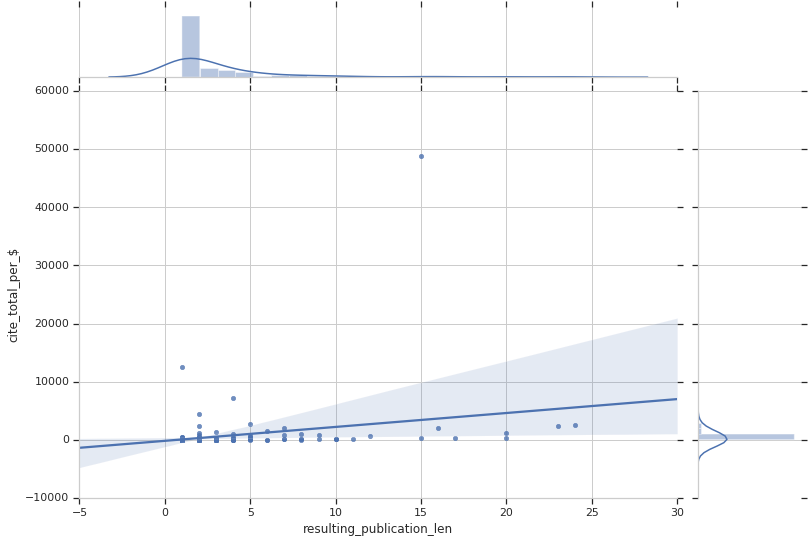

In [148]:
g = sns.jointplot(x="resulting_publication_len", y="cite_total_per_$", 
              data=df_grants.dropna(subset=['cite_total_per_$']),
              kind="reg")
g.fig.set_figwidth(12)
g.fig.set_figheight(8)

In [149]:
df_grants['cite_total_per_$'].describe()

count      185.000000
mean       593.830556
std       3752.390904
min          0.000000
25%          6.666684
50%         39.060035
75%        134.427574
max      48770.620303
Name: cite_total_per_$, dtype: float64